In [ ]:
#Load all libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
import joblib
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, BatchNormalization, Flatten, Concatenate, Layer



# Set display options for pandas
display_options = {
    'display.max_columns': None,
    'display.width': 1000,
}
for option, value in display_options.items():
    pd.set_option(option, value)

# Set seaborn style for visualization
sns.set_style("darkgrid")

# Check TensorFlow and Keras versions
# Check TensorFlow and Keras versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.version.VERSION)


TensorFlow version: 2.18.0
Keras version: 2.18.0


In [ ]:
dataset_path = "/content/dataset_full (1).csv"
data = pd.read_csv(dataset_path)

print("Dataset loaded successfully!")
print("Dataset shape:", data.shape)
print(data.head())


Dataset loaded successfully!
Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url  qty_tld_url  length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_co

In [ ]:
# Step 3: Preprocess the Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Drop missing values and duplicates
data = data.dropna().drop_duplicates()

# Convert boolean columns to integers
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
                   'domain_spf', 'tls_ssl_certificate', 'url_google_index',
                   'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

# Standardize + Normalize numerical columns
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

print("Dataset preprocessing completed.")


Dataset preprocessing completed.



Summary Statistics:
        qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url    qty_at_url   qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url   qty_tld_url    length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_comma_directory  qty_plus_d

<ipython-input-21-5956dd16dd9b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='phishing', data=data, palette='coolwarm')


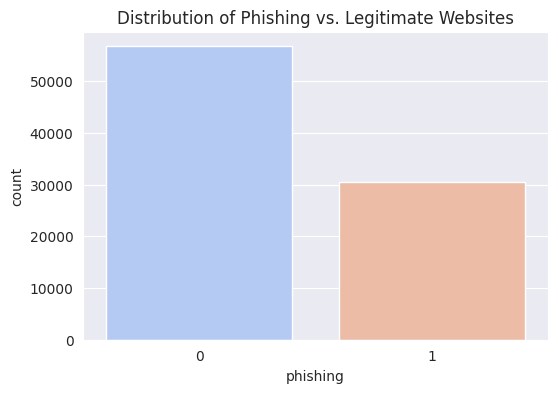

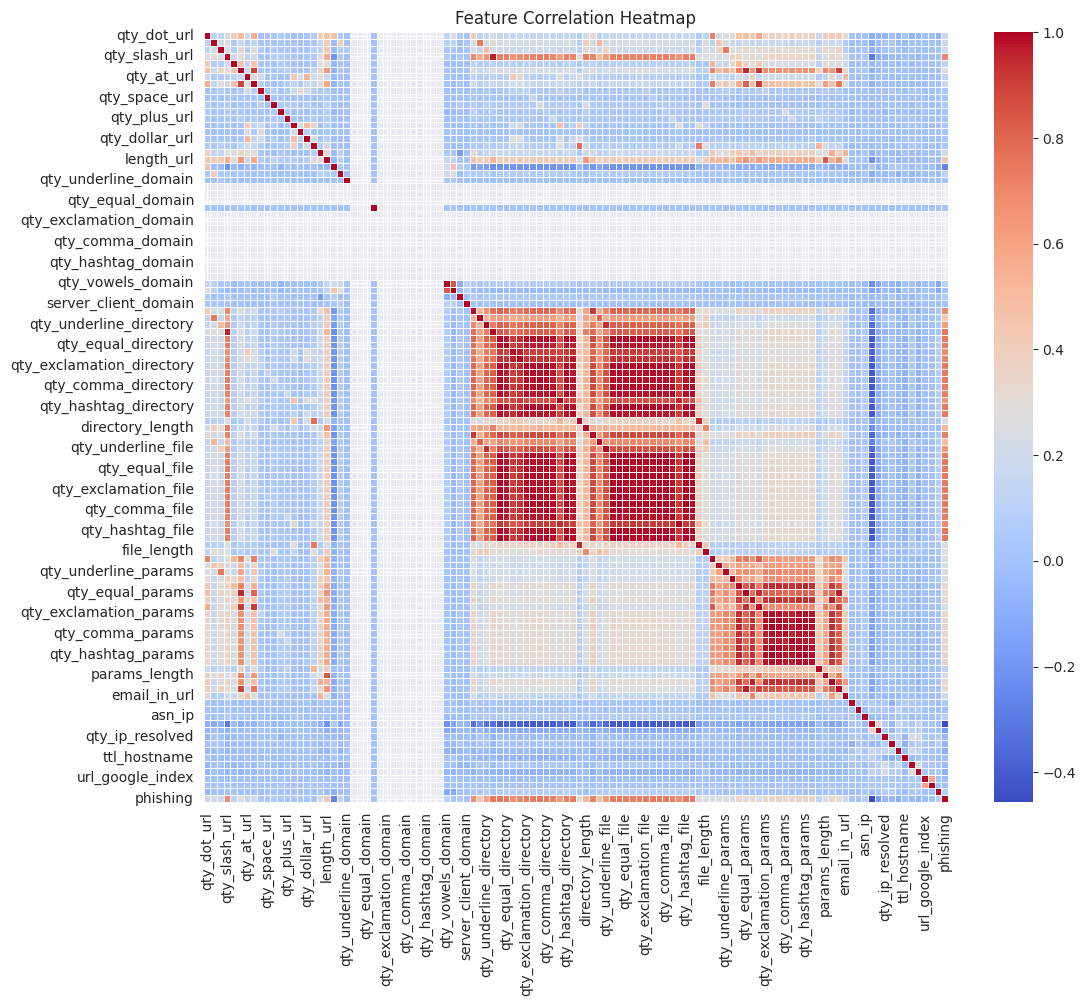

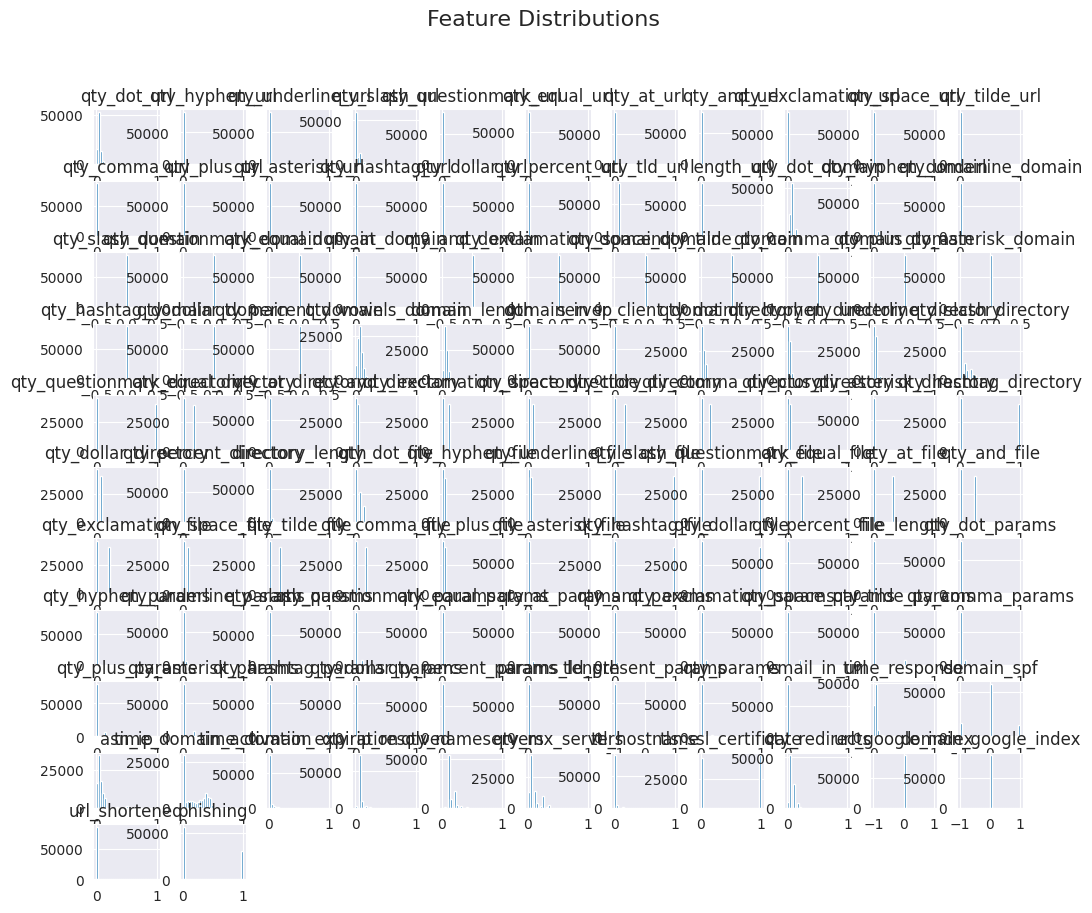

In [ ]:
# Step 4: Exploratory Data Analysis (EDA)
print("\nSummary Statistics:")
print(data.describe())

plt.figure(figsize=(6,4))
sns.countplot(x='phishing', data=data, palette='coolwarm')
plt.title("Distribution of Phishing vs. Legitimate Websites")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

data.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


In [ ]:
# Step 5: Split the dataset into training (80%) and testing (20%) sets
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)



Training set: (69767, 111)
Testing set: (17442, 111)


In [ ]:
# step 6: Reshape Input for LSTM + CNN
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])



In [ ]:
#step 7 model training & attention mechanism
# Core Keras imports
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, BatchNormalization, Flatten, Concatenate, Layer

class NeuralFieldAttention(Layer):
    def __init__(self, units=64):
        super(NeuralFieldAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='b', shape=(self.units,), initializer='zeros', trainable=True)
        self.v = self.add_weight(name='v', shape=(self.units, 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.v, axes=1), axis=1)
        context_vector = attention_weights * inputs
        return tf.reduce_sum(context_vector, axis=1)

# Define model architecture
input_layer = Input(shape=(1, X_train.shape[2]))
lstm = LSTM(64, return_sequences=True)(input_layer)
lstm = Dropout(0.2)(lstm)

cnn = Conv1D(filters=32, kernel_size=1, activation='relu', padding='same')(lstm)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.2)(cnn)

attention_output = NeuralFieldAttention()(cnn)

dense = Dense(128, activation='relu')(attention_output)
dense = Dropout(0.2)(dense)
dense = Dense(64, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'],
    jit_compile=True
)

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1, 111)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 64)               │          45,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1, 32)               │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention_3             │ (None, 32)                  │           2,176 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,985 (242.13 KB)

 Trainable params: 61,921 (241.88 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - AUC: 0.9511 - Precision: 0.8081 - Recall: 0.9058 - accuracy: 0.8912 - loss: 0.2562 - val_AUC: 0.9799 - val_Precision: 0.9205 - val_Recall: 0.8537 - val_accuracy: 0.9231 - val_loss: 0.1844
Epoch 2/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.9754 - Precision: 0.8753 - Recall: 0.9074 - accuracy: 0.9213 - loss: 0.1898 - val_AUC: 0.9818 - val_Precision: 0.8888 - val_Recall: 0.9241 - val_accuracy: 0.9330 - val_loss: 0.1651
Epoch 3/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9775 - Precision: 0.8806 - Recall: 0.9110 - accuracy: 0.9262 - loss: 0.1801 - val_AUC: 0.9837 - val_Precision: 0.8943 - val_Recall: 0.9285 - val_accuracy: 0.9366 - val_loss: 0.1560
Epoch 4/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9790 - Precision: 0.8852 - Recall: 0.9114 - accuracy: 0.9274 - loss: 0.1757 - val_AUC: 0.9828 - val_Precision: 0.8268 - val_Recall: 0.9641 - val_accuracy: 0.9168 - val_loss: 0.1784
Epoch 5/50
1091/1091 

In [ ]:
#steo 8: performance metrics
y_pred_lstmcnn_attn = (model.predict(X_test) > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_lstmcnn_attn)
precision = precision_score(y_test, y_pred_lstmcnn_attn)
recall = recall_score(y_test, y_pred_lstmcnn_attn)
auc = roc_auc_score(y_test, y_pred_lstmcnn_attn)
conf_matrix = confusion_matrix(y_test, y_pred_lstmcnn_attn)

print("\nLSTM + CNN + Attention Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM + CNN + Attention Evaluation:
Accuracy: 0.9545
Precision: 0.9459
Recall: 0.9228
AUC: 0.9472
Confusion Matrix:
[[11021   322]
 [  471  5628]]


In [ ]:
#step 9:Far & Frr Calculations
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]

far = fp / (fp + tn)
frr = fn / (fn + tp)

print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))



FAR: 0.0284
FRR: 0.0772


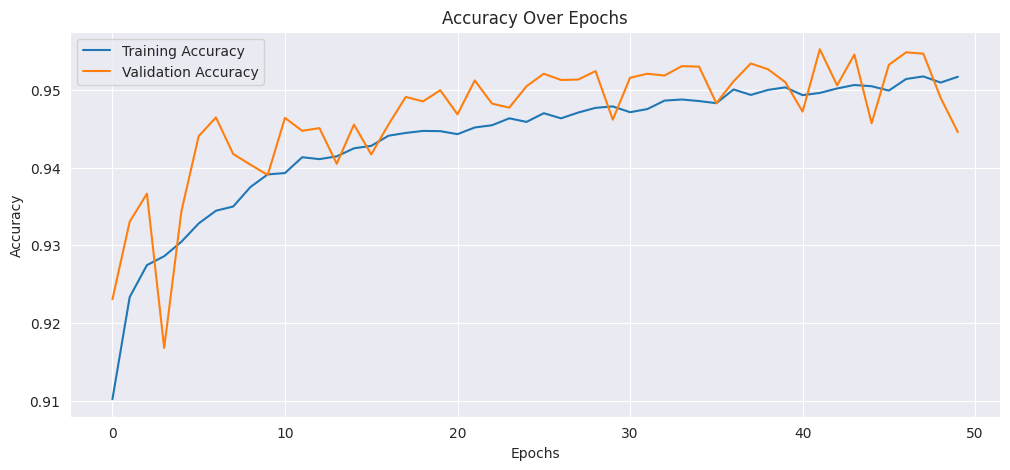

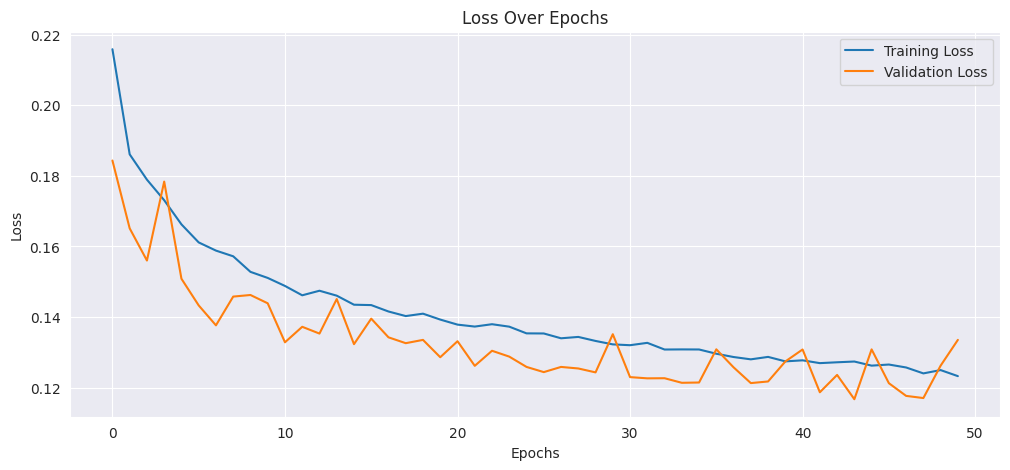

In [ ]:
#Step 9: Plotting
np.save("model_history_LSTM_CNN_ATTENTION.npy", history.history)

plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


FAR & frr calucaltions? not done in every model
attention mechanism
comparision ofresults for other models except gru+lstm
dae code resconstructiion why?
why does the graph change in both the codes
Try lowering the decision threshold (y_pred_prob > 0.45) during prediction(what is the threshold here)

In [ ]:
Comparison of metrics
🧠 Interpretation:
✅ Gains with Attention:
Precision improved: Meaning the model made fewer false positives, i.e., better at not misclassifying legitimate sites as phishing.

FAR decreased: Again confirms that fewer legitimate sites are being wrongly flagged — this is important in user-facing applications.

⚠️ Trade-offs with Attention:
Recall dropped slightly: So the model missed slightly more phishing sites.

FRR increased: This aligns with the recall drop — more false negatives, i.e., phishing sites not caught.

🔍 Confusion Matrix Insights:
Without Attention: Caught 5685 phishing and wrongly missed 414.

With Attention: Caught 5613 phishing and missed 486 — that’s 72 more phishing sites missed, which explains the drop in recall.

🏁 Final Verdict:
If avoiding false alarms is a higher priority (e.g., user trust is key), Attention version wins.

If catching every phishing site is more critical (e.g., security-heavy scenarios), the baseline LSTM+CNN model performs slightly better.

⚖️ It's a classic trade-off: Precision vs Recall, FAR vs FRR.
📊 Comparison Summary
Metric	Without Attention	With Attention	💡 Change
Accuracy	0.9515	0.9545 ✅	↑ slight
Precision	0.9294	0.9459 ✅	↑ better
Recall	0.9321 ✅	0.9228	↓ slight
AUC Score	0.9470	0.9472 ✅	~ same
FAR	0.0381	0.0284 ✅	↓ much better
FRR	0.0679 ✅	0.0772	↑ slightly
🧠 Interpretation
✅ = Better	🚨 = Trade-off
🎯 Precision, Accuracy, AUC, and FAR improved with attention.

🚨 Recall dropped slightly from 0.9321 → 0.9228.

⚖️ This is a classic precision-recall trade-off — attention is making the model more conservative, reducing false positives (FAR), but also missing a few more true positives (↑ FRR).

top info
 LSTM + CNN (Original Architecture Flow)
In this hybrid:

LSTM is applied first to learn temporal/sequential patterns across features.

CNN follows to learn spatial/local patterns across time steps.

Then comes flattening, dense layers, and final classification.

🧠 Where Should Attention Go?
In general, attention mechanisms help the model focus on important time steps or features.

Now, why put attention after both LSTM and CNN?

✅ Reasoning for putting it at the end:
After LSTM and CNN, you get a rich, transformed sequence of features that capture both temporal and spatial information.

Applying attention here allows the model to weigh the most important parts of that composite representation, rather than just temporal (LSTM) or spatial (CNN) alone.

It acts as a refinement step, enhancing the final output by selectively focusing on what matters most after both LSTM and CNN have done their job.

📍 Alternative: Attention after LSTM but before CNN?
You can do this too.

It will help the model focus on important time steps before passing them to CNN.

But it assumes the CNN will retain that importance, which might get lost in convolution.